In [46]:
''' 
What is Concept drift:
When we train the model on old data then our model learned how the attacks looked in last month
But what if attackers changed their behaviour.
Here model will keep guessing the old way and our performance will drop'''

''' 
First we will simulate drift by splitting the data over time.
Then we will train it on early parts and test it on future parts
Then we will monitor performance using partial fitting and learning and calibration curves'''

' \nFirst we will simulate drift by splitting the data over time.\nThen we will train it on early parts and test it on future parts\nThen we will monitor performance using partial fitting and learning and calibration curves'

In [47]:
#Importing libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [48]:
#Load & Preprocess UNSW-NB15_4 Dataset
df = pd.read_csv('C:/Users/Artophilic/Datascience Bootcamp/Network_research/Dataset/UNSW-NB15_4.csv')

In [49]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [50]:
df = df.drop(columns=["proto","service","state","attack_cat"])

In [51]:
df = df.drop(columns=["id"])

In [52]:
df.isnull().sum()

dur                  0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
label                0
dtype: int64

In [53]:
#Splitting the data into independent and dependent data
X = df.drop(columns=['label']).copy()
X.head()
y = df['label'].copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [54]:
#Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

In [55]:
# Convert to binary labels: 1 for normal, -1 for anomaly
y = y.replace({0: 1, 1: -1})

In [56]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
from sklearn.preprocessing import KBinsDiscretizer

# Use KBinsDiscretizer to bin continuous values
binner = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')  # or 'quantile'
X_train_bin = binner.fit_transform(X_train)
X_test_bin = binner.transform(X_test)

X_train_bin = X_train_bin.astype(int)
X_test_bin = X_test_bin.astype(int)

In [58]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [59]:
# Split into 3 segments to simulate time drift
split1 = int(0.3 * len(X_train_bin))
split2 = int(0.6 * len(X_train_bin))

In [60]:
split1

39451

In [61]:
split2

78903

In [62]:
X_t1, y_t1 = X_train_bin[:split1], y_train.values[:split1]
X_t2, y_t2 = X_train_bin[split1:split2], y_train.values[split1:split2]
X_t3, y_t3 = X_train_bin[split2:], y_train.values[split2:]

In [63]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [64]:
# Model
model = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, random_state=42)

In [65]:
# Classes for partial_fit
classes = np.unique(y_train)
classes

array([0, 1])

In [66]:
# Training on old (T1)
model.partial_fit(X_t1, y_t1, classes=classes)
print("Initial training done (T1)")

# Evaluating on future chunks before adaptation
pred_t2 = model.predict(X_t2)
print("\nPerformance on T2 before update:")
print(classification_report(y_t2, pred_t2))

pred_t3 = model.predict(X_t3)
print("\nPerformance on T3 before update:")
print(classification_report(y_t3, pred_t3))

# Adapting using T2 (simulate online update)
model.partial_fit(X_t2, y_t2)

# Evaluate again after adaptation
pred_t3_updated = model.predict(X_t3)
print("\nPerformance on T3 after update:")
print(classification_report(y_t3, pred_t3_updated))

Initial training done (T1)

Performance on T2 before update:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     12528
           1       0.91      0.89      0.90     26924

    accuracy                           0.87     39452
   macro avg       0.85      0.86      0.85     39452
weighted avg       0.87      0.87      0.87     39452


Performance on T3 before update:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80     16834
           1       0.91      0.90      0.90     35768

    accuracy                           0.87     52602
   macro avg       0.85      0.85      0.85     52602
weighted avg       0.87      0.87      0.87     52602


Performance on T3 after update:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80     16834
           1       0.91      0.90      0.90     35768

    accuracy                           0.87     52602


SHAP (SHapley Additive exPlanations) explains how much each feature contributes to a model’s decision

In [67]:
import shap

In [68]:
#Setting up the shap explainer for the SGDClassifier
#As SGDClassifier is a linear, we will use SHAP's LinearExplainer

In [69]:
# Picking a sample of test data for SHAP
X_sample = X_test_bin[:100]

In [70]:
# Creating SHAP explainer
explainer = shap.LinearExplainer(model, X_train_bin, feature_perturbation="interventional", feature_names=df.columns)

c:\Users\Artophilic\anaconda3\envs\netvenv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [71]:
# Computing SHAP values for test samples
shap_values = explainer.shap_values(X_sample)

In [72]:
shap_values

array([[-0.02525746,  0.        ,  0.        , ..., -0.01437517,
         0.00704394,  0.10544683],
       [-0.02525746,  0.        ,  0.        , ..., -0.01437517,
         0.00704394,  0.10544683],
       [-0.02525746,  0.        ,  0.        , ..., -0.01437517,
         0.00704394,  0.10544683],
       ...,
       [-0.02525746,  0.        ,  0.        , ..., -0.01437517,
         0.00704394,  0.10544683],
       [-0.02525746,  0.        ,  0.        , ..., -0.01437517,
         0.00704394,  0.10544683],
       [-0.02525746,  0.        ,  0.        , ..., -0.01437517,
         0.00704394,  0.10544683]], shape=(100, 39))

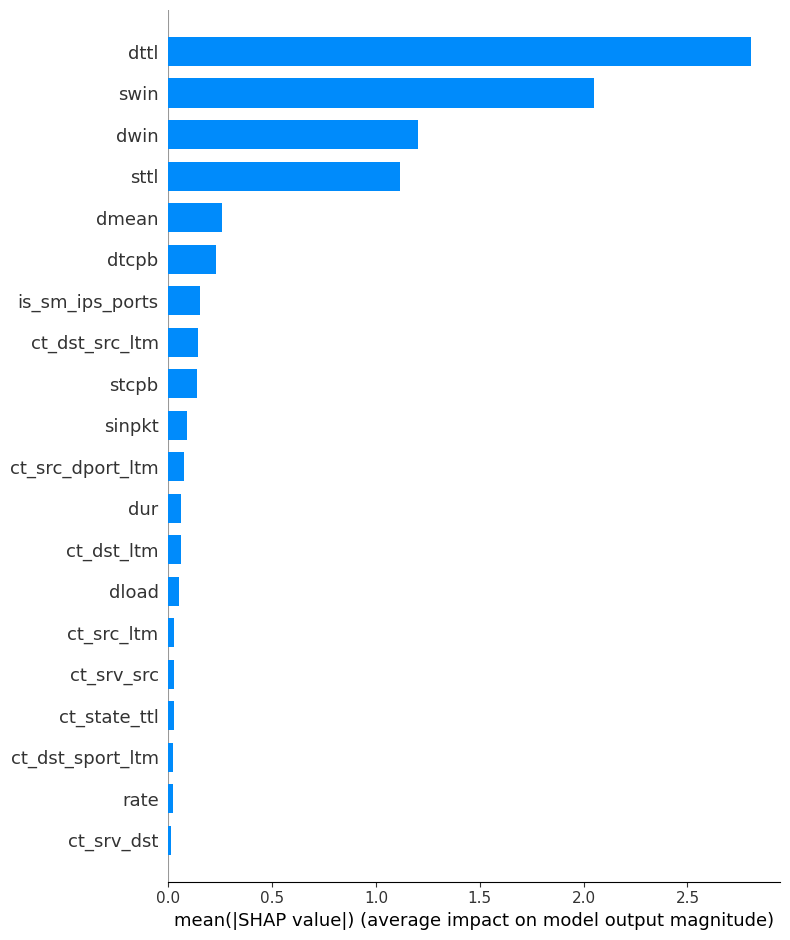

In [73]:
# Plotting mean absolute SHAP value for each feature
shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=df.columns)

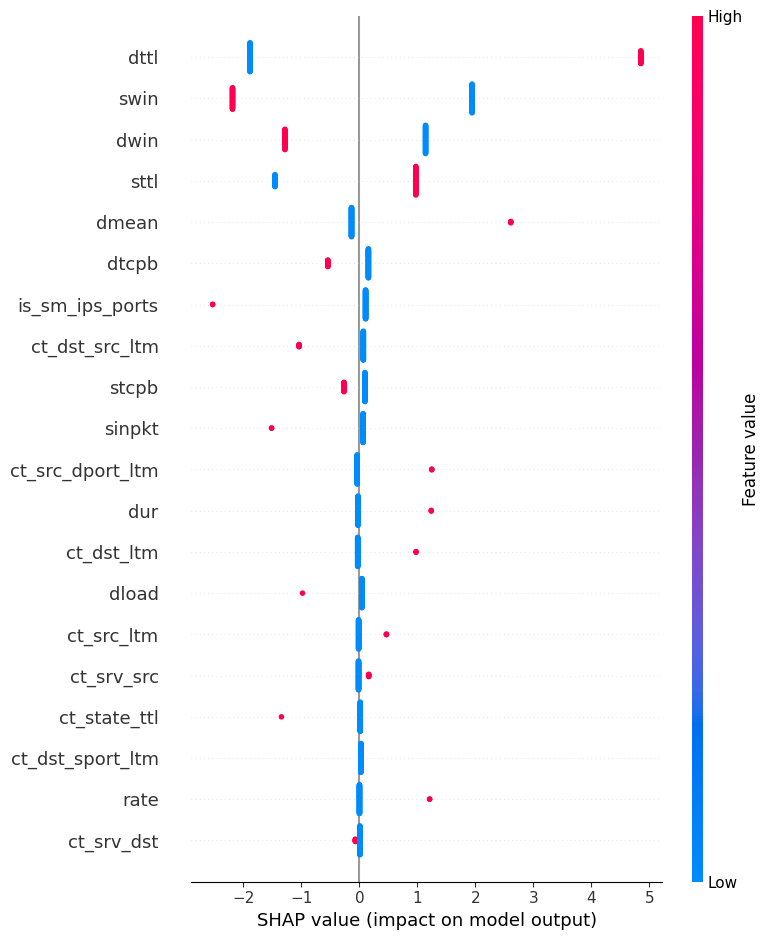

In [74]:
# Beeswarm plot to show how each feature pushes prediction toward normal/anomaly
shap.summary_plot(shap_values, X_sample, feature_names=df.columns)

In [75]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    X_sample[0].astype(float)  # Make sure it's float, not np.int64
)